# APM466 Assignment 2: Swing Options

In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
def generate_asset_tree(N, u, d, p0):
    '''
    Generates a binomial tree for the price evolvement of the underlying.
        N - number of periods
        u - up factor
        d - down factor
        p0 - initial price of the underlying
    '''
    asset_tree = np.zeros((N+1, N+1))
    for j in range(N+1):
        for i in range(j+1):
            asset_tree[i][j] = p0 * math.pow(d, i) * math.pow(u, j-i)
    
    return asset_tree

def payoff(p, call, K): 
    '''
    Calculates the payoff of exercising an option.
        p - price of the underlying at time of exercise
        call - indicator variable for the option type
            = 1 for a call option
            = 0 for a put option
        K - strike price of the option
    '''            
    if call == 1:
        payoff = max(p-K, 0)
    else:
        payoff = max(K-p, 0)
    
    return payoff

def get_forest_payoff(asset_tree, K, call, N, p, rights, amt):
    '''
    Generates a forest of binomial trees for the option payoff, and populates
    it with payoffs at each node through back propagation.
        asset_tree - pre-populated binomial tree for price of the underlying
        K - strike price of the option
        call - indicator variable for the option type
            = 1 for a call option
            = 0 for a put option
        N - number of periods
        p - current price of the underlying
        rights - maximum number of rights (exercises) for the swing option
        amt - exercise amount specified by the option
    '''    
    #### initialize the forest ####
    forest = []
    exer_time = []
   
    for r in range(rights): # number of rights exercised = 0, 1, ..., r-1
        forest.append(np.zeros((N+1, N+1)))
        if call == 1:
            forest[r][:,-1] = np.maximum(amt*(asset_tree[:,-1]-K), 0)
        else:
            forest[r][:,-1] = np.maximum(amt*(K-asset_tree[:,-1]), 0)
        exer_time.append([])
    
    forest.append(np.zeros((N+1, N+1))) # all rights exercised -> payoffs = 0

    #### calculate payoffs at each node ####
    for t in range(rights-1, -1, -1):
        for j in range(N, 0, -1):
            for i in range(j, 0, -1):
                exercise = amt*payoff(asset_tree[i-1,j-1], call, K) + \
                           (1-p)*forest[t+1][i,j]+ p*forest[t+1][i-1,j]
                stay = (1-p)*forest[t][i,j]+ p*forest[t][i-1,j]
                forest[t][i-1,j-1] = max(stay, exercise)
                if exercise > stay+1e-26:
                    exer_time[t].append((i-1,j-1))
            
    return forest, exer_time

In [16]:
#### calculate the price for the 4-upswing option ####
N = int(52)                 # number of steps (total number of weeks)
strike = 1                  # strike price of the swing option
p0 = 1                      # initial price of gasoline
up = 1.1                    # up factor of underlying price
down = 1/1.1                # down factor of underlying price
p = (1-down)/(up-down)      # risk-neutral probability measure
rights = 4                  # numer of rights for the swing option
amt = 50                    # exercise amount

call_asset_tree = generate_asset_tree(N, up, down, p0)
call_payoff = get_forest_payoff(call_asset_tree, strike, 1, N, p, rights, amt)
print("The price of Mr. Hamilton's price protection plan is: ", call_payoff[0][0][0,0])

The price of Mr. Hamilton's price protection plan is:  53.014634751614594


In [17]:
#### calculate the price for the 4-downswing option ####
N = int(52)                 # number of steps (total number of weeks)
strike = 1                  # strike price of the swing option
p0 = 1                      # initial price of gasoline
up = 1.1                    # up factor of underlying price
down = 1/1.1                # down factor of underlying price
p = (1-down)/(up-down)      # risk-neutral probability measure
rights = 4                  # numer of rights for the swing option
amt = 50000                 # exercise amount

put_asset_tree = generate_asset_tree(N, up, down, p0)
put_payoff = get_forest_payoff(put_asset_tree, strike, 0, N, p, rights, amt)
print("The price of Ms. Curie's price protection plan is: ", put_payoff[0][0][0,0])

The price of Ms. Curie's price protection plan is:  53014.634751614605


In [66]:
def plot_exercise_node(call_payoff, put_payoff, rights):
    call_x = []
    call_y = []
    put_x = []
    put_y = []
    empty_x = []
    empty_y = []

    for node in (call_payoff[1][rights]):
        call_y.append(52-node[0])
        call_x.append(node[1])
    for node in (put_payoff[1][rights]):
        put_y.append(52-node[0])
        put_x.append(node[1])

    all_nodes = []
    for i in range(52):
        for j in range(i,52):
            all_nodes.append((i,j))
    empty = set(all_nodes)-set(call_payoff[1][rights])-set(put_payoff[1][rights])
    
    for node in (empty):
        empty_y.append(52-node[0])
        empty_x.append(node[1])

    plt.figure(figsize=(20,20))
    plt.scatter(call_x, call_y, edgecolor="red", color="red", s=100)
    plt.scatter(put_x, put_y, color="blue", edgecolor="blue", s=100)
    plt.scatter(empty_x, empty_y, color="none", edgecolor="green", s=100)
    plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlim([0, 52])
    plt.ylim([0, 53])

    lgnd = plt.legend(
           ('Exercise Nodes for Upswing Option', 'Exercise Nodes for Downswing Option', 'Regular Nodes in the Tree'),
           scatterpoints=1,
           loc='lower left',
           fontsize=25)
    
    for handle in lgnd.legendHandles:
        handle.set_sizes([100])

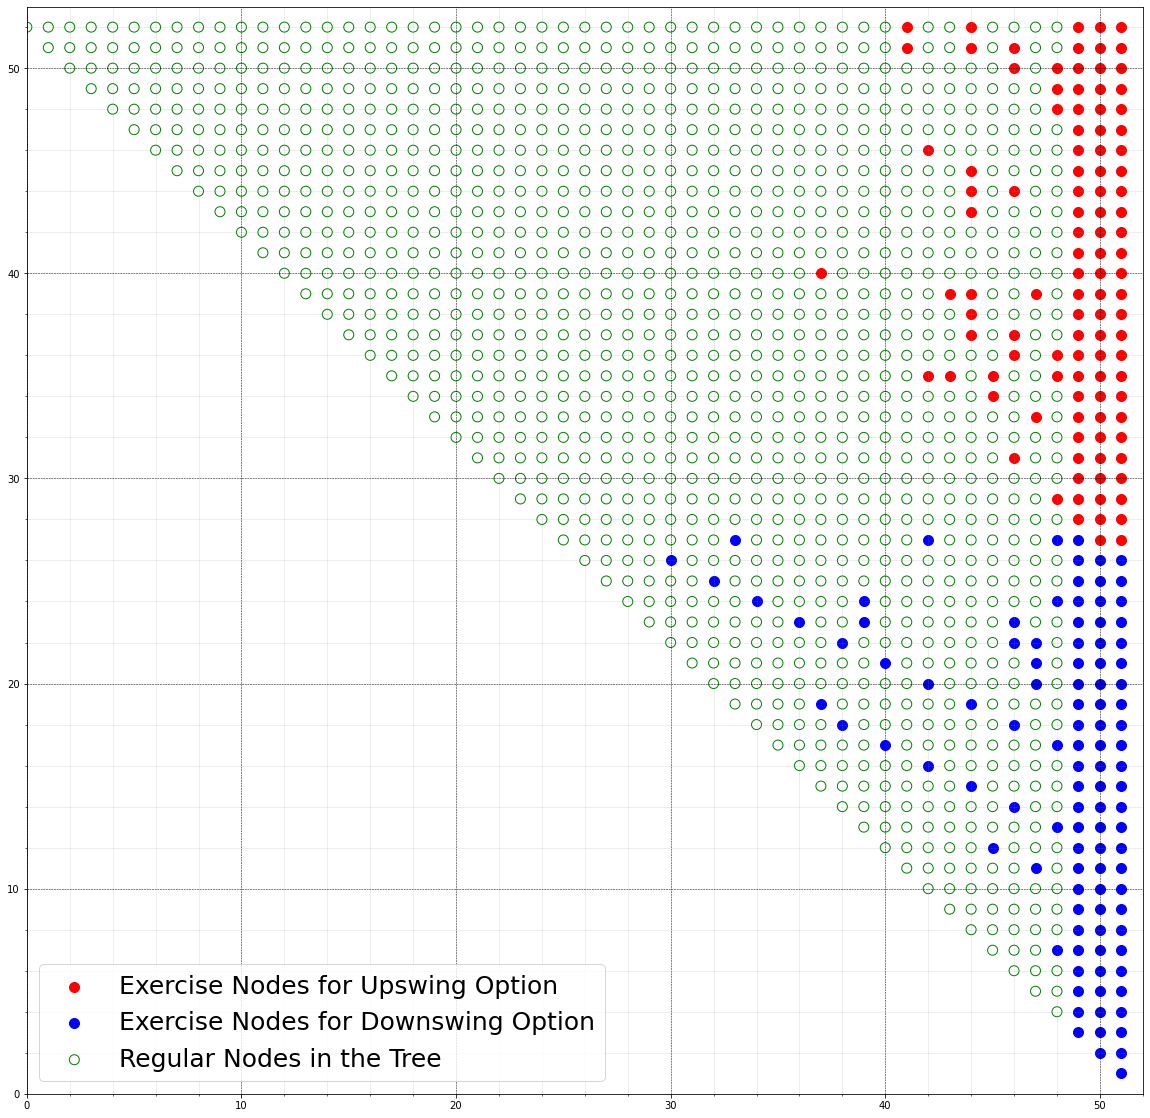

In [67]:
plot_exercise_node(call_payoff, put_payoff, 0)

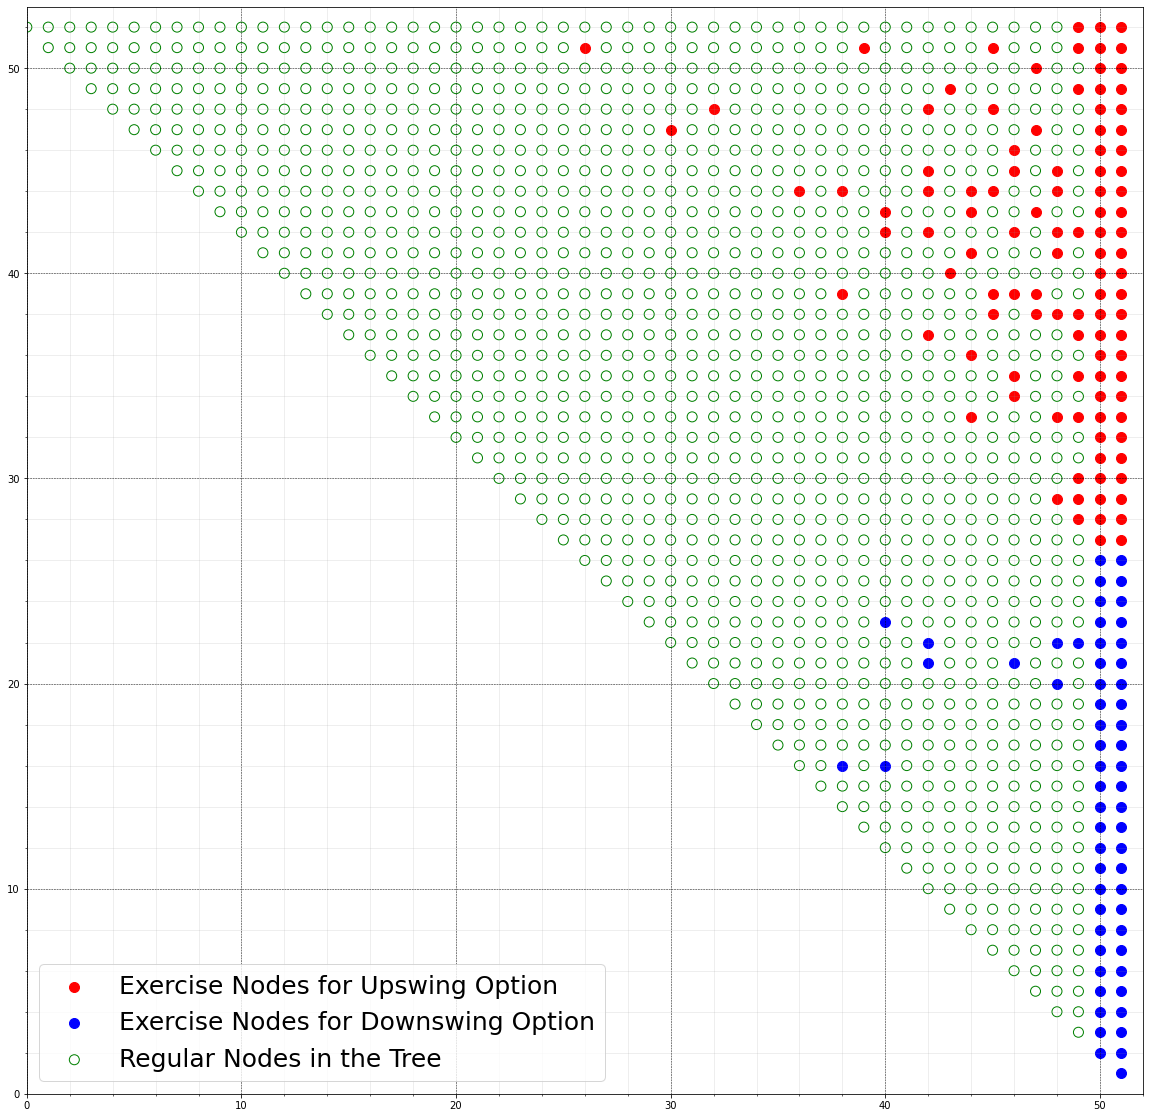

In [68]:
plot_exercise_node(call_payoff, put_payoff, 1)

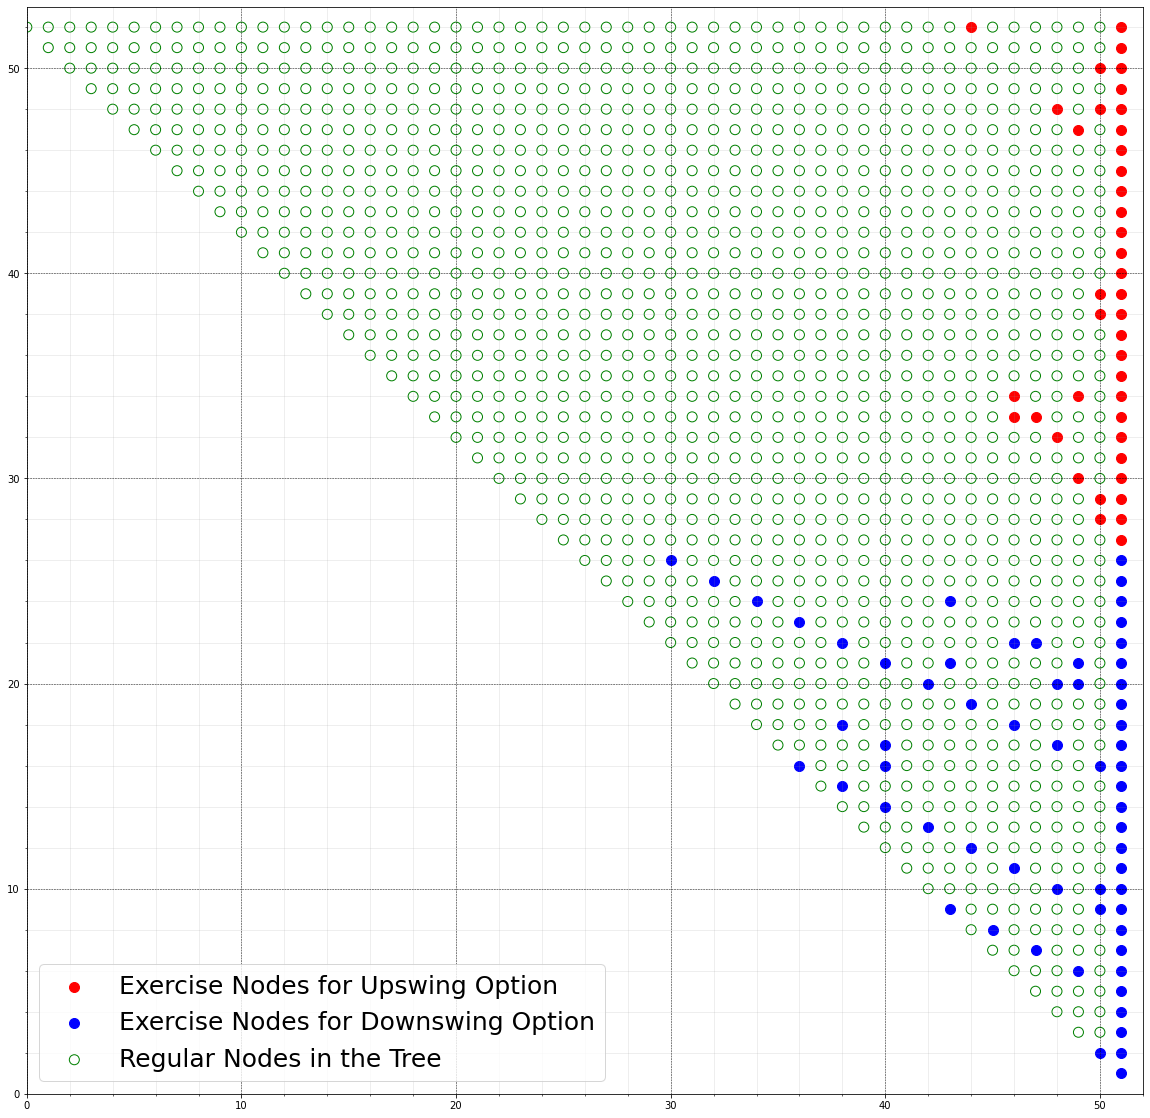

In [69]:
plot_exercise_node(call_payoff, put_payoff, 2)

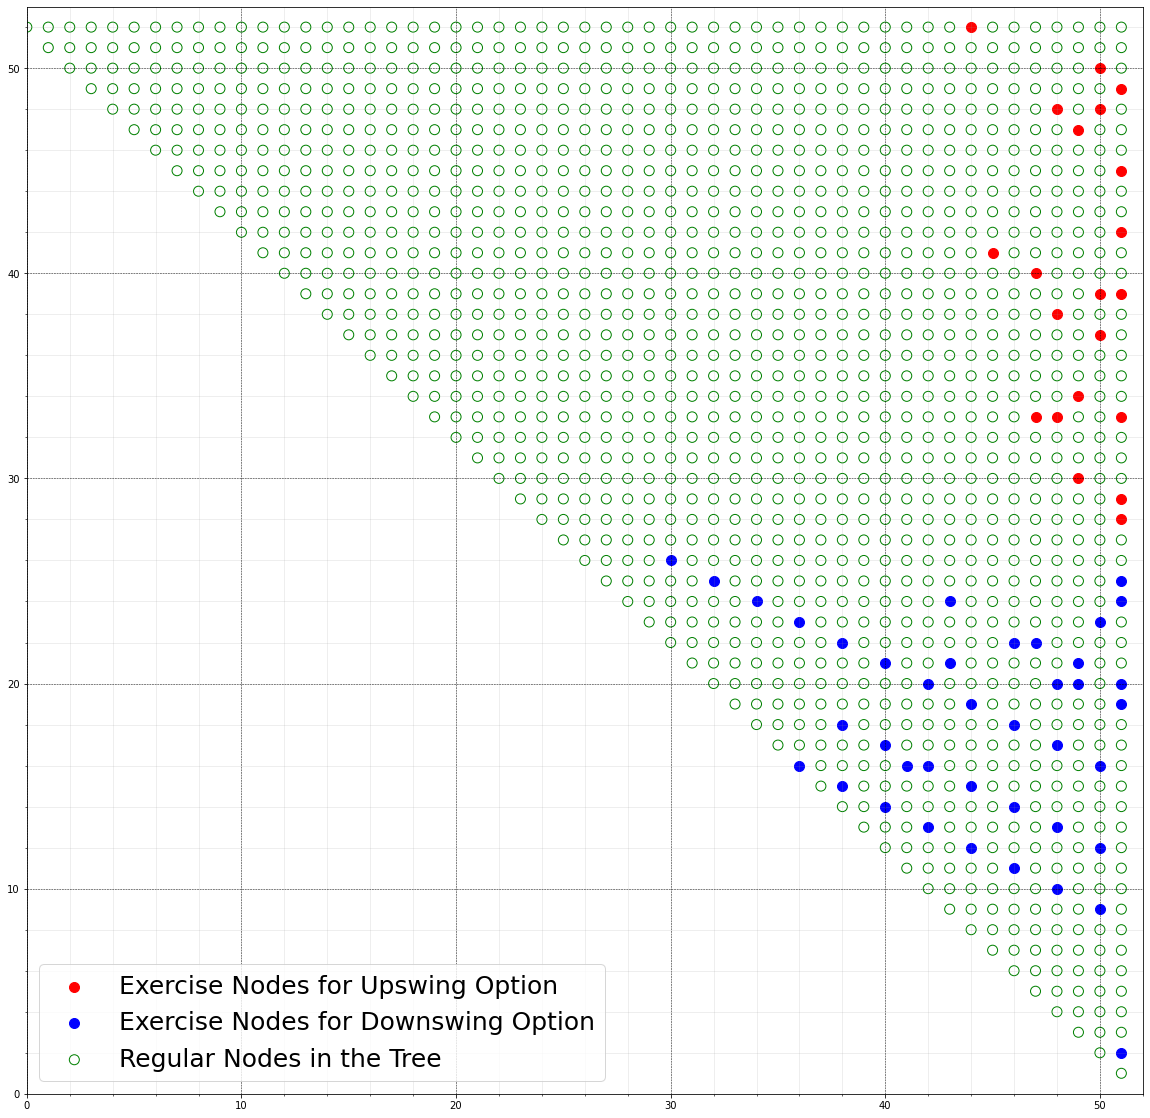

In [70]:
plot_exercise_node(call_payoff, put_payoff, 3)